# Team Based Model

## Imports

In [707]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import xgboost as xgb


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [537]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [616]:
team_data = load_team_data()

In [617]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)

In [618]:
clean_team_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,HOME_GAME
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,0,240,34,74,0.459,2,9,0.222,28,40,0.700,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,0.529,1.00,14.1,0.289,0.667,0.478,18.256,18.9,0.473,0.535,1.0,0.197,98.32,95.5,79.58,95.0,0.446,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.563,0.438,0.000,1.000,0.529,0.471,1
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,1,240,43,88,0.489,6,11,0.545,14,16,0.875,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,0.674,1.81,20.7,0.333,0.711,0.522,16.320,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96.0,0.554,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.622,0.378,1.000,0.000,0.674,0.326,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276,0.698,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.750,0.250,1.000,0.000,0.774,0.226,1
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302,0.724,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.467,0.533,1.000,0.000,0.500,0.500,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,240,36,80,0.450,4,17,0.235,9,13,0.692,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,0.528,1.12,15.6,0.239,NaN,NaN,18.139,18.1,0.475,0.496,1.0,0.199,93.06,94.0,78.33,94.0,0.359,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.469,0.531,1.000,0.000,0.528,0.472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,1,240,35,79,0.443,14,39,0.359,18,21,0.857,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,0.714,1.67,19.5,0.289,0.783,0.538,16.088,16.3,0.532,0.578,1.0,0.200,93.84,92.0,76.67,92.0,0.559,0.506,0.494,0.412,0.078,0.412,0.069,0.176,0.186,0.333,0.619,0.381,0.857,0.143,0.714,0.286,0
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,1,240,38,83,0.458,14,33,0.424,21,22,0.955,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,0.684,2.00,19.7,0.267,0.667,0.467,13.446,14.0,0.542,0.599,1.0,0.199,95.46,93.5,77.92,93.0,0.512,0.602,0.398,0.432,0.144,0.378,0.036,0.189,0.180,0.288,0.542,0.458,0.929,0.071,0.684,0.316,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,0,240,38,82,0.463,14,38,0.368,18,21,0.857,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,0.553,1.40,16.5,0.333,0.733,0.533,15.917,16.0,0.549,0.592,1.0,0.200,95.46,93.5,77.92,94.0,0.488,0.537,0.463,0.444,0.056,0.389,0.231,0.167,0.130,0.389,0.458,0.542,0.714,0.286,0.553,0.447,1
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,0,240,35,79,0.443,10,28,0.357,13,22,0.591,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-

In [619]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,1,108,-3,0,240,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,94.0,0.488,6,24,14,42,10,13,9,4
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,1,93,-13,0,240,0,25,51,10,28,13,22,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-10.9,-12.8,93.0,0.456,6,7,14,43,18,7,7,3


In [620]:
from src.data import make_team_dataset

matchups = make_team_dataset.create_matchups(ready_for_agg_df)

matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,TEAM_SCORE_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,98,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102678,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,96,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0
102681,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111

In [621]:
from src.data.make_team_dataset import get_team_and_opp_avg
avg_data = get_team_and_opp_avg(matchups)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.24it/s]


In [622]:
avg_data

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,115.2,242.5,0.6,28.6,54.6,13.5,38.4,17.5,22.7,9.3,34.0,43.3,25.0,9.3,6.9,15.3,22.7,115.2,1.0,105.67,107.63,103.95,107.11,1.74,0.51,107.0,0.4942,6.1,17.0,21.0,50.7,14.4,13.5,9.8,3.1
51340,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901278,2020-08-07,NOP vs. WAS,1,118,11,1,242.5,0.4,31.7,58.4,11.7,33.7,17.3,25.3,11.7,35.9,47.6,28.3,8.1,3.5,17.5,21.1,115.8,-1.6,106.33,109.58,108.91,110.73,-2.60,-1.14,105.7,0.5030,8.5,14.6,14.7,54.4,17.2,13.6,10.1,0.8,117.4,242.5,0.6,28.8,54.8,13.8,37.3,18.4,23.9,9.2,32.9,42.1,24.9,9.4,6.0,14.5,22.7,117.4,1.6,108.91,110.73,106.33,109.58,2.60,1.14,10

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [623]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [624]:
avg_data_2 = add_percentage_features(avg_data)


In [625]:
avg_data_3 = add_rest_days(avg_data_2)
avg_data_3

..\src\features\build_team_features.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')


,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,OREB_PCT_team,DREB_PCT_team,REB_PCT_team,TS_PCT_team,EFG_PCT_team,AST_RATIO_team,TOV_PCT_team,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_opp,DREB_PCT_opp,REB_PCT_opp,TS_PCT_opp,EFG_PCT_opp,AST_RATIO_opp,TOV_PCT_opp,rest
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000023,2000-11-02,HOU vs. MIL,1,115,22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,2000-01,22000,1610612745,HOU,Houston Rockets,20000044,2000-11-04,HOU @ LAC,0,74,-3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000048,2000-11-05,HOU @ PHX,0,99,-5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2000-01,22000,1610612745,HOU,Houston Rockets,20000058,2000-11-07,HOU vs. LAL,1,84,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,2019-20,22019,1610612740,NOP,New Orleans Pelicans,21901268,2020-08-06,NOP @ SAC,0,125,-15,0,242.5,0.4,31.5,59.5,11.1,33.0,17.9,26.0,11.8,37.3,49.1,28.3,8.7,3.4,17.8,20.9,114.2,-1.0,103.95,107.11,105.67,107.63,-1.74,-0.51,106.6,0.5058,7.8,17.2,15.6,54.5,17.8,12.8,9.5,0.9,0.257642,0.800429,0.531385,0.581348,0.520541,26.547842,14.621324,242.5,0.6,28.6,54.6,1

In [576]:
avg_data_3 = avg_data_3.dropna()
        

In [626]:
home_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 1]
away_teams = avg_data_3.loc[avg_data_3['HOME_GAME_team'] == 0]
away_teams = away_teams.drop(columns = ['GAME_DATE_team',
                                        'SEASON_YEAR_team',
                                        'SEASON_ID_team',
                                        'TEAM_ID_team',
                                        'TEAM_ABBREVIATION_team',
                                        'TEAM_NAME_team',
                                        'GAME_DATE_team',
                                        'MATCHUP_team',
                                        'HOME_GAME_team',
                                        'point_diff_team',
                                        'WL_team'])

full_df = pd.merge(home_teams, away_teams, on='GAME_ID')
full_df = full_df.dropna()

new_cols = []
for col in full_df.columns:
    if col.endswith('_x'):
        col = 'HOME_' + col[:-2]
    if col.endswith('_y'):
        col = 'AWAY_' + col[:-2]
    if col.endswith('_team'):
        col = col[:-5]
        
    new_cols.append(col)
    
full_df.columns = new_cols


columns = full_df.columns.tolist()
columns.remove('AWAY_TEAM_SCORE')
columns.insert(10, 'AWAY_TEAM_SCORE')

full_df = full_df[columns]

In [627]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest
3,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,78,7,1,240.0,0.400000,26.800000,59.400000,5.800000,16.200000,23.000000,29.400000,11.800000,27.400000,39.200000,19.0,8.600000,4.200000,16.600000,22.000000,94.000000,3.200000,100.720000,103.160,98.420000,99.200000,2.280000,3.940000,91.000000,0.511000,18.000000,7.000000,18.200000,34.600000,14.20,12.000000,4.600000,1.000000,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.600000,29.600000,62.000000,4.800000,13.200000,17.200000,24.000000,10.200000,28.800000,39.000000,20.400000,6.600000,4.400000,16.600000,23.000000,90.800000,-3.200000,98.420000,99.200000,100.720000,103.160,-2.280000,-3.940000,91.400000,0.489000,23.200000,7.800000,17.600000,35.200000,15.600000,13.400000,4.400,0.200000,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.000,0.800000,31.400000,69.800000,3.600000,12.000000,22.400000,30.400000,12.800000,32.400000,45.200000,22.800000,9.800000,3.800000,16.200000,24.000000,96.000000,8.400000,97.460000,99.4800,90.120000,90.340000,7.360000,9.120000,96.600000,0.576000,25.600000,9.800000,20.800000,36.000000,19.000000,11.800000,3.400000,0.200000,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.000,0.200000,30.600000,67.800000,3.600000,13.200000,15.600000,23.000000,13.200000,31.000000,44.200000,18.000000,8.600000,8.000000,19.400000,25.200000,87.600000,-8.400000,90.120000,90.340000,97.460000,99.4800,-7.360000,-9.120000,9

In [377]:
abs(full_df['point_diff']).mean()

10.969488148117398

## Add ELO Rating

In [673]:
for idx, row in full_df.iterrows():
    print(row['MATCHUP'][-3:])
    break

MEM


In [674]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    
    # If the home team wins
    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(home_score, away_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_home, S_away = 0, 0
    if home_score > away_score:
        S_home = 1
    else:
        S_away = 1
    return S_home, S_away


def elo_prediction(home_rating, away_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_home = 1.0/(1 + 10 ** ((away_rating - home_rating) / (400.0)))
    return E_home


def elo_update(home_score, away_score, home_rating, away_rating):
    # Add 100 to the home_rating for home court advantage
    HOME_AD = 100
    home_rating += HOME_AD
    
    
    E_home = elo_prediction(home_rating, away_rating)
    E_away = 1.0 - E_home
    
    MOV = home_score - away_score
    
    if MOV > 0:
        elo_diff = home_rating - away_rating
    else:
        elo_diff = away_rating - home_rating
        
    
    S_home, S_away = get_S(home_score, away_score)
    
    K_home, K_away = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_home, E_away)
#     print("elo_diff:", elo_diff)
#     print("S_home:", S_home, "S_away:", S_away)
#     print("K_home:", K_home, "K_away:", K_away)
#     print(K_home*(S_home-E_home), K_away*(S_away-E_away))
    return K_home*(S_home-E_home), K_away*(S_away-E_away)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [676]:
def get_elo_ratings(df = full_df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

        if row['TEAM_ABBREVIATION'] not in elo_dic:
            elo_dic[row['TEAM_ABBREVIATION']] = 1300
            df.loc[idx, 'home_rating_i'] = 1300
        else:
            df.loc[idx, 'home_rating_i'] = elo_dic[row['TEAM_ABBREVIATION']]

        away_team_abbr = row['MATCHUP'][-3:]
        if away_team_abbr not in elo_dic:
            elo_dic[away_team_abbr] = 1300
            df.loc[idx, 'away_rating_i'] = 1300
        else:
            df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['HOME_TEAM_SCORE']
        away_score = row['AWAY_TEAM_SCORE']
        home_rating = elo_dic[row['TEAM_ABBREVIATION']]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[row['TEAM_ABBREVIATION']] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return None

get_elo_ratings(df = full_df)

In [677]:
full_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_score,away_score,spread,total,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000076,2000-11-09,HOU vs. MEM,1,85,78,7,1,240.0,0.400000,26.800000,59.400000,5.800000,16.200000,23.000000,29.400000,11.800000,27.400000,39.200000,19.0,8.600000,4.200000,16.600000,22.000000,94.000000,3.200000,100.720000,103.160,98.420000,99.200000,2.280000,3.940000,91.000000,0.511000,18.000000,7.000000,18.200000,34.600000,14.20,12.000000,4.600000,1.000000,0.290640,0.728723,0.501279,0.572696,0.469577,20.879121,15.789073,240.0,0.600000,29.600000,62.000000,4.800000,13.200000,17.200000,24.000000,10.200000,28.800000,39.000000,20.400000,6.600000,4.400000,16.600000,23.000000,90.800000,-3.200000,98.420000,99.200000,100.720000,103.160,-2.280000,-3.940000,91.400000,0.489000,23.200000,7.800000,17.600000,35.200000,15.600000,13.400000,4.400,0.200000,0.271277,0.709360,0.498721,0.564115,0.489362,22.319475,16.217272,2.0,240.000,0.800000,31.400000,69.800000,3.600000,12.000000,22.400000,30.400000,12.800000,32.400000,45.200000,22.800000,9.800000,3.800000,16.200000,24.000000,96.000000,8.400000,97.460000,99.4800,90.120000,90.340000,7.360000,9.120000,96.600000,0.576000,25.600000,9.800000,20.800000,36.000000,19.000000,11.800000,3.400000,0.200000,0.292237,0.710526,0.505593,0.542446,0.449878,23.602484,14.545324,240.000,0.200000,30.600000,67.800000,3.600000,13.200000,15.600000,23.000000,13.200000,31.000000,44.200000,18.000000

## Add Betting Data

In [628]:
from src.data.make_betting_dataset import clean_bet_data
betting_data = pd.read_csv("../data/nba_betting_data_2010_present.csv")

bet_data_clean = clean_bet_data(betting_data)


In [921]:
moneyline_df = pd.read_csv("../data/all_moneylines.csv", parse_dates=['game_date'])
moneyline_df

,away_team,home_team,game_date,away_moneyline,home_moneyline
0,Miami,Boston,2010-10-26,"['-', '-', '-115', '-']","['-', '-', '-105', '-']"
1,Phoenix,Portland,2010-10-26,"['+255', '+270', '+270', '-']","['-310', '-330', '-320', '-']"
2,Houston,L.A. Lakers,2010-10-26,"['+265', '+260', '+260', '-']","['-330', '-310', '-310', '-']"
3,Detroit,Brooklyn,2010-10-27,"['+155', '+155', '+155', '-']","['-175', '-175', '-175', '-']"
4,Boston,Cleveland,2010-10-27,"['-190', '-190', '-190', '-']","['+165', '+160', '+160', '-']"
...,...,...,...,...,...
24644,Atlanta,Miami,2021-02-28,"['+120', '+120', '+125', '+120']","['-140', '-140', '-145', '-140']"
24645,Memphis,Houston,2021-02-28,"['-165', '-170', '-163', '-165']","['+145', '+150', '+142', '+145']"
24646,Golden State,L.A. Lakers,2021-02-28,"['-220', '+125', '+122', '+125']","['+160', '-145', '-143', '-145']"
24647,Phoenix,Minnesota,2021-02-28,"['-600', '-530', '-594', '-560']","['+400', '+425', '+443', '+435']"


In [954]:
moneyline_df['home_team'].unique()
abbr_mapping = {'Boston':'BOS', 'Portland':'POR', 
                'L.A. Lakers':'LAL', 'Brooklyn':'BKN', 
                'Cleveland':'CLE', 'Toronto':'TOR',
                'Philadelphia':'PHI', 'Memphis':'MEM',
                'Minnesota':'MIN', 'New Orleans':'NOP',
               'Oklahoma City':'OKC', 'Dallas':'DAL', 
                'San Antonio':'SAS', 'Denver':'DEN', 
                'Golden State':'GSW', 'L.A. Clippers':'LAC', 
                'Orlando':'ORL', 'Utah':'UTA', 
                'Charlotte':'CHA', 'Detroit':'DET',
               'Miami':'MIA', 'Phoenix':'PHX',
                'Atlanta':'ATL', 'New York':'NYK', 
                'Indiana':'IND', 'Chicago':'CHI',
               'Houston':'HOU', 'Milwaukee':'MIL',
                'Sacramento':'SAC', 'Washington':'WAS'}

moneyline_df['home_team'] = moneyline_df['home_team'].replace(abbr_mapping)
moneyline_df['away_team'] = moneyline_df['away_team'].replace(abbr_mapping)

# moneyline_df['away_moneyline1'] = moneyline_df['away_moneyline'].apply(lambda x: x[0])
away_mls = moneyline_df['away_moneyline'].str.split(',', expand=True)
away_mls.columns = ['away_ml1', 'away_ml2', 'away_ml3', 'away_ml4']
home_mls = moneyline_df['home_moneyline'].str.split(',', expand=True)
home_mls.columns = ['home_ml1', 'home_ml2', 'home_ml3', 'home_ml4']

mls = pd.concat([moneyline_df, away_mls, home_mls], axis=1)

mls = mls.drop(columns=['away_moneyline', 'home_moneyline', 'away_moneyline1'])

for col in mls.columns[3:]:
    mls[col] = mls[col].str.replace('[', '')
    mls[col] = mls[col].str.replace(']', '')
    mls[col] = mls[col].str.replace("'", '')
    
mls

,away_team,home_team,game_date,away_ml1,away_ml2,away_ml3,away_ml4,home_ml1,home_ml2,home_ml3,home_ml4
0,MIA,BOS,2010-10-26,-,-,-115,-,-,-,-105,-
1,PHX,POR,2010-10-26,+255,+270,+270,-,-310,-330,-320,-
2,HOU,LAL,2010-10-26,+265,+260,+260,-,-330,-310,-310,-
3,DET,BKN,2010-10-27,+155,+155,+155,-,-175,-175,-175,-
4,BOS,CLE,2010-10-27,-190,-190,-190,-,+165,+160,+160,-
...,...,...,...,...,...,...,...,...,...,...,...
24644,ATL,MIA,2021-02-28,+120,+120,+125,+120,-140,-140,-145,-140
24645,MEM,HOU,2021-02-28,-165,-170,-163,-165,+145,+150,+142,+145
24646,GSW,LAL,2021-02-28,-220,+125,+122,+125,+160,-145,-143,-145
24647,PHX,MIN,2021-02-28,-600,-530,-594,-560,+400,+425,+443,+435


,away_team,home_team,game_date,away_ml1,away_ml2,away_ml3,away_ml4,home_ml1,home_ml2,home_ml3,home_ml4
0,MIA,BOS,2010-10-26,-,-,-115,-,-,-,-105,-
1,PHX,POR,2010-10-26,+255,+270,+270,-,-310,-330,-320,-
2,HOU,LAL,2010-10-26,+265,+260,+260,-,-330,-310,-310,-
3,DET,BKN,2010-10-27,+155,+155,+155,-,-175,-175,-175,-
4,BOS,CLE,2010-10-27,-190,-190,-190,-,+165,+160,+160,-
...,...,...,...,...,...,...,...,...,...,...,...
24644,ATL,MIA,2021-02-28,+120,+120,+125,+120,-140,-140,-145,-140
24645,MEM,HOU,2021-02-28,-165,-170,-163,-165,+145,+150,+142,+145
24646,GSW,LAL,2021-02-28,-220,+125,+122,+125,+160,-145,-143,-145
24647,PHX,MIN,2021-02-28,-600,-530,-594,-560,+400,+425,+443,+435


In [629]:
full_df = pd.merge(full_df, bet_data_clean, how='left', left_on = ['TEAM_ABBREVIATION', 'GAME_DATE'], right_on=['home_team_abbr', 'date'])

In [630]:
full_df = full_df.drop(columns = ['date', 'home_team_abbr', 'away_team_abbr'])

In [631]:
full_df['spread'].isnull().sum()

13847

In [926]:
full_df['TEAM_ABBREVIATION'].unique()

array(['HOU', 'POR', 'CHA', 'PHX', 'MIN', 'DAL', 'LAC', 'NYK', 'BKN',
       'CHI', 'SAS', 'IND', 'CLE', 'PHI', 'MIL', 'GSW', 'DEN', 'SAC',
       'DET', 'LAL', 'OKC', 'MIA', 'ATL', 'BOS', 'MEM', 'WAS', 'TOR',
       'UTA', 'ORL', 'NOP'], dtype=object)

## Feature Selection

We have quite a lot of features. First let's see how well ELO does at predicting the spread.

### Starting Simple: Using ELO to predict the Spread

In [698]:
home_team_wins_baseline = (win_test == 1).mean()
print("baseline predicting home team every time:", home_team_wins_baseline)

baseline predicting home team every time: 0.5773858921161825


In [844]:
full_df[full_df['SEASON_YEAR'] == '2016-17']
full_df[full_df['SEASON_YEAR'] == '2016-17'].index[0]

19329

In [856]:
full_df = full_df.sort_values('GAME_DATE').reset_index()

In [865]:
full_df.loc[cutoff_15:cutoff_16]

,index,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,HOME_TEAM_SCORE,AWAY_TEAM_SCORE,point_diff,WL,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_OREB_PCT,HOME_DREB_PCT,HOME_REB_PCT,HOME_TS_PCT,HOME_EFG_PCT,HOME_AST_RATIO,HOME_TOV_PCT,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_OREB_PCT_opp,HOME_DREB_PCT_opp,HOME_REB_PCT_opp,HOME_TS_PCT_opp,HOME_EFG_PCT_opp,HOME_AST_RATIO_opp,HOME_TOV_PCT_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_OREB_PCT,AWAY_DREB_PCT,AWAY_REB_PCT,AWAY_TS_PCT,AWAY_EFG_PCT,AWAY_AST_RATIO,AWAY_TOV_PCT,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_OREB_PCT_opp,AWAY_DREB_PCT_opp,AWAY_REB_PCT_opp,AWAY_TS_PCT_opp,AWAY_EFG_PCT_opp,AWAY_AST_RATIO_opp,AWAY_TOV_PCT_opp,AWAY_rest,home_score,away_score,spread,total,home_elo_pred,home_rating_i,home_rating_n,away_rating_i,away_rating_n,elo_MOV_pred
18091,18661,2015-16,22015,1610612741,CHI,Chicago Bulls,21500070,2015-11-05,CHI vs. OKC,1,104,98,6,1,245.0,0.6,28.2,59.8,9.8,25.4,14.8,19.8,7.0,36.2,43.2,20.0,7.0,5.8,16.2,21.0,100.6,-1.4,97.68,99.98,99.08,100.94,-1.40,-0.98,100.8,0.4992,18.6,11.6,14.6,37.4,11.2,16.0,7.0,2.0,0.162791,0.718254,0.462527,0.561660,0.503521,19.841270,14.712293,245.0,0.4,32.4,72.0,7.2,22.4,15.6,22.6,14.2,36.0,50.2,22.0,7.6,5.8,13.2,17.6,102.0,1.4,99.08,100.94,97.68,99.98,1.40,0.98,101.2,0.5008,20.6,9.8,17.0,43.8,15.6,16.0,6.0,0.6,0.281746,0.837209,0.537473,0.513223,0.457627,21.739130,11.229837,2.0,250.0,0.6,34.0,66.2,9.2,23.4,18.6,22.8,14.2,36.4,50.6,23.0,7.8,8.4,20.6,24.6,114.2,4.6,107.58,109.50,101.80,104.52,5.76,4.98,104.4,0.5280,18.6,13.8,15.4,48.0,16.0,17.2,6.4,2.4,0.328704,0.771186,0.559735,0.603492,0.533482,22.030651,17.133542,250.0,0.4,32.2,68.4,8.0,23.4,21.2,27.6,10.8,29.0,39.8,20.2,12.2,6.4,14.2,20.8,109.6,-4.6,101.80,104.52,107.58,109.50,-5.76,-4.98,104.6,0.4720,13.2,12.4,18.6,49.6,13.6,18.0,6.0,1.8,0.228814,0.671296,0.440265,0.559915,0.481481,19.311663,12.019231,1.0,104.0,98.0,-1.0,212.0,0.446231,1543.752881,1552.582106,1681.260589,1672.431364,-1.34
18092,18617,2015-16,22015,1610612757,POR,Portland Trail Blazers,21500074,2015-11-05,POR vs. MEM,1,115,96,19,1,240.0,0.6,28.8,55.6,9.8,28.2,14.6,22.6,10.2,36.2,46.4,17.6,6.6,5.4,17.2,25.2,101.6,2.0,101.02,101

In [917]:
features = full_df[['home_rating_i', 'away_rating_i', 'home_elo_pred', 'elo_MOV_pred', 'HOME_rest', 'AWAY_rest', 'HOME_FG3M', 'HOME_FG3M_opp', 'AWAY_FG3M', 'AWAY_FG3M_opp']]
point_diff = full_df['point_diff']
win = full_df['WL']

cutoff_15 = int(full_df[full_df['SEASON_YEAR'] == '2015-16'].index[0])
cutoff_16 = int(full_df[full_df['SEASON_YEAR'] == '2016-17'].index[0])
cutoff_17 = int(full_df[full_df['SEASON_YEAR'] == '2017-18'].index[0])
cutoff_18 = int(full_df[full_df['SEASON_YEAR'] == '2018-19'].index[0])
cutoff_19 = int(full_df[full_df['SEASON_YEAR'] == '2019-20'].index[0])

cutoffs = [cutoff_15, cutoff_16, cutoff_17, cutoff_18, cutoff_19]

In [918]:
def train_model():
    features = full_df[['home_rating_i', 'away_rating_i', 'home_elo_pred', 'elo_MOV_pred', 'HOME_rest', 'AWAY_rest', 
                        'HOME_FG3M', 'HOME_FG3M_opp', 'AWAY_FG3M', 'AWAY_FG3M_opp',
                       'HOME_EFG_PCT', 'HOME_EFG_PCT_opp', 'AWAY_EFG_PCT', 'AWAY_EFG_PCT_opp']]
    point_diff = full_df['point_diff']
    win = full_df['WL']
    
    result_dfs = []
    
    for i in range(len(cutoffs)):
        if i == len(cutoffs) - 1:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:, :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:]
        else:
            X_train = features.iloc[:cutoffs[i], :]
            X_test = features.iloc[cutoffs[i]:cutoffs[i+1], :]
            point_diff_train = point_diff.iloc[:cutoffs[i]]
            point_diff_test = point_diff.iloc[cutoffs[i]:cutoffs[i+1]]
        
        pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

        pipeline.fit(X_train, point_diff_train)
        lr_preds = pipeline.predict(X_test)

        mse = mean_squared_error(point_diff_test, lr_preds)
        mae = mean_absolute_error(point_diff_test, lr_preds)
        print("season {}".format(i+2015))
        print("mse:", mse, "mae:", mae)
        print(list(zip(features.columns, pipeline.named_steps['linreg'].coef_)))
        
        if i == len(cutoffs) - 1:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:]
            
        else:
            betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoffs[i]:cutoffs[i+1]]
            
        betting_results['model_preds'] = lr_preds
        betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
        betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
        betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        betting_results['model_spread_diff'] = abs(-betting_results['model_preds'] - betting_results['spread'])
        
        select_bets = betting_results.loc[((betting_results['model_spread_diff'].between(3,6)))
                                 & (abs(betting_results['spread']) < 10)]
        
        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

season 2015
mse: 144.55939501662064 mae: 9.455225889739822
[('home_rating_i', 189.1168661782679), ('away_rating_i', -187.4299593937739), ('home_elo_pred', 2.4696247695702866), ('elo_MOV_pred', -230.06959232072953), ('HOME_rest', 0.3179082319743662), ('AWAY_rest', -0.6523673783235122), ('HOME_FG3M', -0.09812600352431812), ('HOME_FG3M_opp', 0.054515769274484524), ('AWAY_FG3M', -0.46142092840735427), ('AWAY_FG3M_opp', -0.046412023708563815), ('HOME_EFG_PCT', 0.6461333845724191), ('HOME_EFG_PCT_opp', -0.45195902938463844), ('AWAY_EFG_PCT', -0.5511086192467685), ('AWAY_EFG_PCT_opp', 0.5486567258141306)]


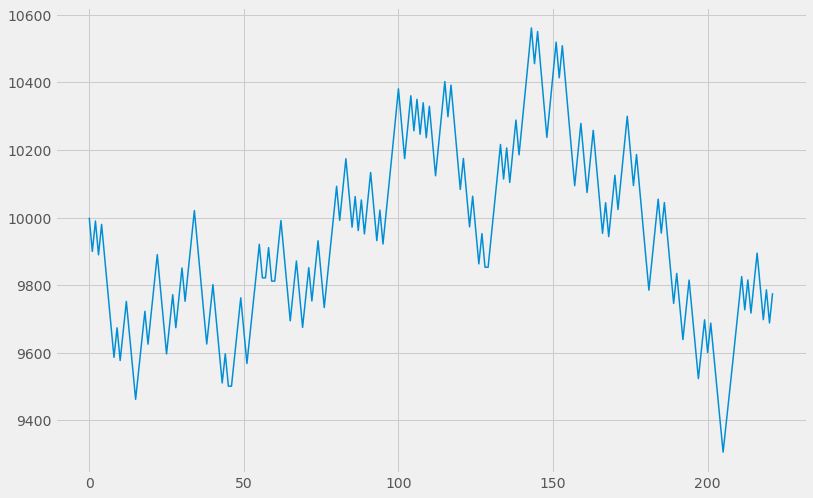

min balance: 9306.239289246188 
max balance: 10561.353408369583 
final balance: 9678.735301941952 
win percentage 51.83
season 2016
mse: 166.35396599772835 mae: 10.074462922827657
[('home_rating_i', 108.28448594369097), ('away_rating_i', -107.23649821659032), ('home_elo_pred', 2.534901973987932), ('elo_MOV_pred', -131.30381589371206), ('HOME_rest', 0.35015320292795354), ('AWAY_rest', -0.6155482398019851), ('HOME_FG3M', -0.04784191986396989), ('HOME_FG3M_opp', -0.03295527684743634), ('AWAY_FG3M', -0.3979184764858607), ('AWAY_FG3M_opp', -0.008793398363203126), ('HOME_EFG_PCT', 0.6197778875018857), ('HOME_EFG_PCT_opp', -0.39806785582686494), ('AWAY_EFG_PCT', -0.5975991718638077), ('AWAY_EFG_PCT_opp', 0.5528734106077504)]


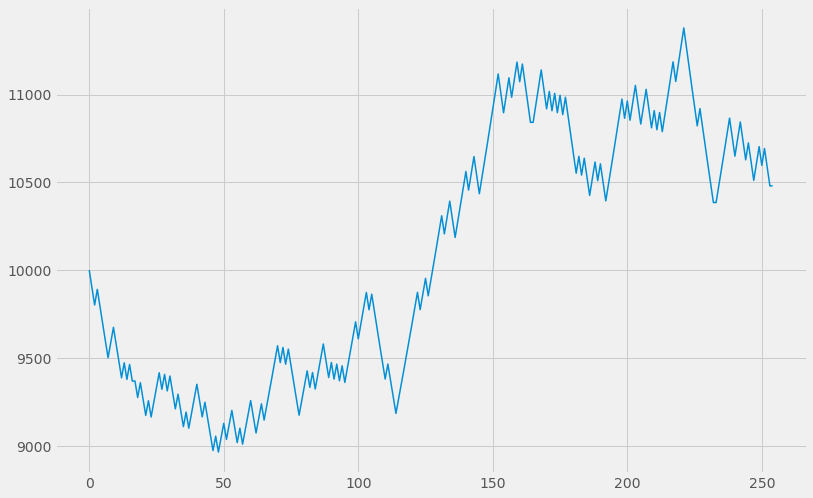

min balance: 8963.157495627538 
max balance: 11379.14675886246 
final balance: 10574.801236753065 
win percentage 53.779999999999994
season 2017
mse: 159.9902637708612 mae: 9.818966471053207
[('home_rating_i', 125.74324428250013), ('away_rating_i', -124.73086691899474), ('home_elo_pred', 2.265833428647839), ('elo_MOV_pred', -153.25088291147142), ('HOME_rest', 0.37868641467050024), ('AWAY_rest', -0.6108578029600719), ('HOME_FG3M', -0.02400690812028085), ('HOME_FG3M_opp', 0.014407317186896388), ('AWAY_FG3M', -0.41847816269313937), ('AWAY_FG3M_opp', 0.055583942350312), ('HOME_EFG_PCT', 0.6317809460421125), ('HOME_EFG_PCT_opp', -0.398720754918111), ('AWAY_EFG_PCT', -0.607638533990861), ('AWAY_EFG_PCT_opp', 0.529417772105611)]


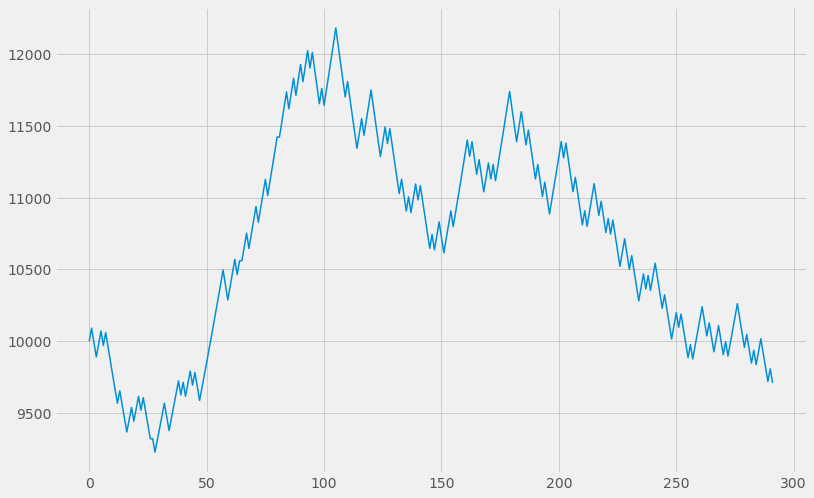

min balance: 9227.865257162333 
max balance: 12180.810503093322 
final balance: 9797.85915968151 
win percentage 52.25
season 2018
mse: 173.51790543581558 mae: 10.265811696102682
[('home_rating_i', 96.61583511236998), ('away_rating_i', -95.70302712083615), ('home_elo_pred', 2.3711987577961837), ('elo_MOV_pred', -117.6038733291568), ('HOME_rest', 0.37316041515283216), ('AWAY_rest', -0.5906269088139229), ('HOME_FG3M', -0.049217148211803986), ('HOME_FG3M_opp', -0.009232526160824315), ('AWAY_FG3M', -0.4892250057572545), ('AWAY_FG3M_opp', 0.06945559397519845), ('HOME_EFG_PCT', 0.639892349481292), ('HOME_EFG_PCT_opp', -0.38585495260649394), ('AWAY_EFG_PCT', -0.6411497334199998), ('AWAY_EFG_PCT_opp', 0.5711786623248701)]


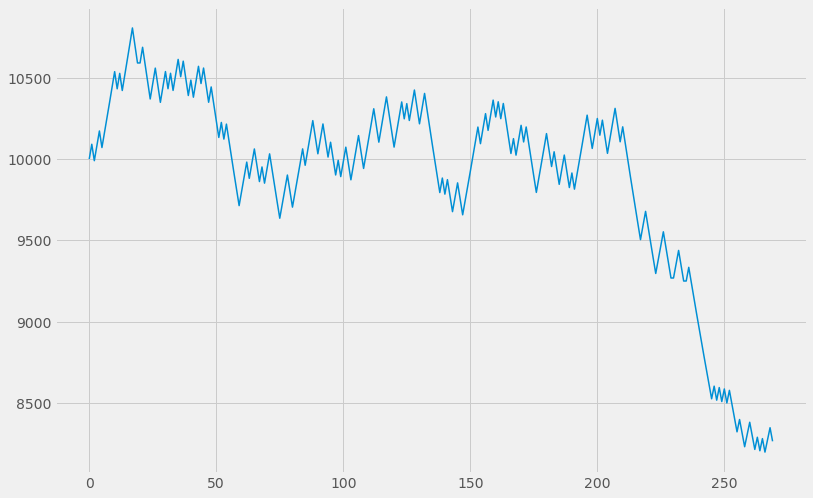

min balance: 8200.283274308058 
max balance: 10805.244426776864 
final balance: 8341.70698615924 
win percentage 49.059999999999995
season 2019
mse: 181.9121872975019 mae: 10.496325805558762
[('home_rating_i', 108.90585047375322), ('away_rating_i', -107.80600952647565), ('home_elo_pred', 2.345626516190725), ('elo_MOV_pred', -133.21803445413235), ('HOME_rest', 0.38749402562008023), ('AWAY_rest', -0.607408832016695), ('HOME_FG3M', 0.035324589380196766), ('HOME_FG3M_opp', 0.055440864319824895), ('AWAY_FG3M', -0.5170712502276853), ('AWAY_FG3M_opp', -0.006210576707674225), ('HOME_EFG_PCT', 0.6394895523013078), ('HOME_EFG_PCT_opp', -0.46730678337151005), ('AWAY_EFG_PCT', -0.6202084258256402), ('AWAY_EFG_PCT_opp', 0.6091439558794041)]


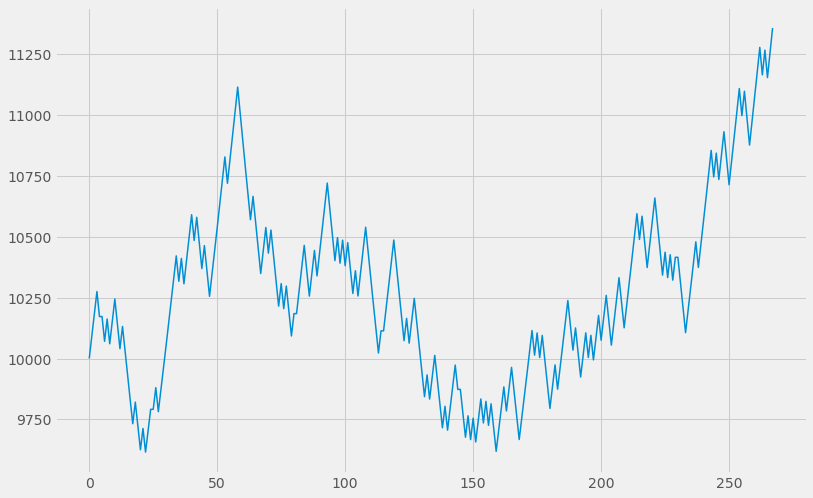

min balance: 9616.011583810194 
max balance: 11357.429519561701 
final balance: 11357.429519561701 
win percentage 55.169999999999995


In [919]:
result_dfs = train_model()

In [885]:
result_dfs[0]

,index,GAME_DATE,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size,model_spread_diff
0,18095,2015-11-06,4.0,-6,-0.950774,1,0.0,0.0,10000.000000,9900.000000,100.000000,3.049226
1,18096,2015-11-06,1.0,3,4.223504,1,1.0,1.0,9900.000000,9990.000000,99.000000,5.223504
2,18099,2015-11-07,-5.5,-4,8.697232,1,0.0,0.0,9990.000000,9890.100000,99.900000,3.197232
3,18107,2015-11-08,-8.5,21,14.040410,1,1.0,1.0,9890.100000,9980.010000,98.901000,5.540410
4,18108,2015-11-08,-3.0,20,-0.565893,0,1.0,0.0,9980.010000,9880.209900,99.800100,3.565893
...,...,...,...,...,...,...,...,...,...,...,...,...
240,19218,2016-04-11,-2.5,9,5.767212,1,1.0,1.0,9955.514130,10046.018803,99.555141,3.267212
241,19227,2016-04-12,1.5,-6,3.802571,1,0.0,0.0,10046.018803,9945.558615,100.460188,5.302571
242,19230,2016-04-13,-4.5,-5,0.007067,0,0.0,1.0,9945.558615,10035.972785,99.455586,4.492933
243,19238,2016-04-13,3.5,5,-6.802859,0,1.0,0.0,10035.972785,9935.613057,100.359728,3.302859


In [792]:
pipeline = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

pipeline.fit(X_train, point_diff_train)
lr_preds = pipeline.predict(X_test)

mse = mean_squared_error(point_diff_test, lr_preds)
mae = mean_absolute_error(point_diff_test, lr_preds)
print("mse:", mse, "mae:", mae)



mse: 169.56679019296 mae: 10.157444151073072


In [695]:
pipeline = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression())])

pipeline.fit(X_train, win_train)
log_r_preds = pipeline.predict(X_test)

accuracy = log_r_preds = pipeline.score(X_test, win_test)
print(accuracy)

0.654149377593361


In [800]:
betting_results = full_df[['GAME_DATE', 'spread', 'point_diff']].iloc[cutoff:, :]
betting_results['model_preds'] = lr_preds


betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bankroll_i'].iloc[0] = 10000
betting_results['bet_size'] = np.nan

betting_results['model_spread_diff'] = abs(-betting_results['model_preds'] - betting_results['spread'])

betting_results


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,GAME_DATE,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size,model_spread_diff
19276,2016-02-29,-4.5,5,5.179438,1,1.0,1.0,10000.0,NaN,NaN,0.679438
19277,2016-03-02,-6.0,23,3.220438,0,1.0,0.0,NaN,NaN,NaN,2.779562
19278,2016-03-04,-10.0,1,9.561774,0,0.0,1.0,NaN,NaN,NaN,0.438226
19279,2016-03-09,-11.5,20,6.835732,0,1.0,0.0,NaN,NaN,NaN,4.664268
19280,2016-03-11,-4.5,-4,5.262234,1,0.0,0.0,NaN,NaN,NaN,0.762234
...,...,...,...,...,...,...,...,...,...,...,...
24091,2020-03-06,-1.5,6,-2.273892,0,1.0,0.0,NaN,NaN,NaN,3.773892
24092,2020-07-30,-2.5,-2,-0.820037,0,0.0,1.0,NaN,NaN,NaN,3.320037
24093,2020-08-03,-5.0,10,2.422231,0,1.0,0.0,NaN,NaN,NaN,2.577769
24094,2020-08-07,-8.0,11,7.072408,0,1.0,0.0,NaN,NaN,NaN,0.927592


### Betting only on games where our model's predictions differs a certain range from vegas

In [824]:
betting_strat1 = betting_results

spread_model_range = []
bet_win_percentages = []
tn, fp, fn, tp = [], [], [], []
games_bet = []
low, high, final = [], [], []


for n in range(1, 16):
    for m in range(0, n):
        select_bets = betting_results.loc[(betting_results['model_spread_diff'] < n) & (betting_results['model_spread_diff']>=m)]
        select_bets = select_bets.loc[select_bets['home_cover'] != 0.5]
        try:
#             print(m, n)
#             print(select_bets[['home_cover', 'bet_home']])
#             print(confusion_matrix(select_bets['home_cover'], select_bets['bet_home']))
            a, b, c, d = confusion_matrix(select_bets['home_cover'], select_bets['bet_home']).ravel()
            tn.append(a)
            fp.append(b)
            fn.append(c)
            tp.append(d)
        except:
            print("error at m={}, n={}".format(m, n))
            tn.append(np.nan)
            fp.append(np.nan)
            fn.append(np.nan)
            tp.append(np.nan)
        win_pct = select_bets['bet_won'].mean()
        bet_win_percentages.append(win_pct)
        games_bet.append(select_bets.shape[0])
        spread_model_range.append((m, n))

results = pd.DataFrame({'spread_model_diff':spread_model_range,
              'games_bet':games_bet,
              'percent_bets_won':bet_win_percentages, 
              'false_pos':fp, 
              'false_neg':fn,
             'true_neg':tn,
             'true_pos':tp})



In [825]:
results.sort_values('percent_bets_won', ascending=False).head(20)

,spread_model_diff,games_bet,percent_bets_won,false_pos,false_neg,true_neg,true_pos
104,"(13, 14)",3,0.666667,0,1,0,2
118,"(13, 15)",5,0.600000,1,1,1,2
103,"(12, 14)",18,0.555556,4,4,3,7
117,"(12, 15)",20,0.550000,5,4,4,7
20,"(5, 6)",310,0.545161,78,63,70,99
44,"(8, 9)",98,0.540816,28,17,19,34
53,"(8, 10)",150,0.533333,46,24,27,53
90,"(12, 13)",15,0.533333,4,3,3,5
2,"(1, 2)",936,0.533120,214,223,250,249
19,"(4, 6)",771,0.533074,210,150,187,224


In [828]:
select_bets = betting_results.loc[((betting_results['model_spread_diff'].between(3,6)))
                                 & (abs(betting_results['spread']) < 10)]
# select_bets['bet_won'] == 1
(select_bets['bet_won'] == 1).sum()*100 + (select_bets['bet_won'] == 0).sum()*-110
select_bets

,GAME_DATE,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size,model_spread_diff
19301,2015-12-31,-2.0,-6,-1.776719,0,0.0,1.0,NaN,NaN,NaN,3.776719
19302,2016-01-06,-8.0,-9,2.011333,0,0.0,1.0,NaN,NaN,NaN,5.988667
19304,2016-01-15,-3.5,2,0.402801,0,0.0,1.0,NaN,NaN,NaN,3.097199
19316,2016-02-27,-2.0,-2,6.414521,1,0.0,0.0,NaN,NaN,NaN,4.414521
19319,2016-03-07,1.5,3,3.884947,1,1.0,1.0,NaN,NaN,NaN,5.384947
...,...,...,...,...,...,...,...,...,...,...,...
24084,2020-01-31,-7.5,28,1.593433,0,1.0,0.0,NaN,NaN,NaN,5.906567
24087,2020-02-13,-3.5,-5,0.445249,0,0.0,1.0,NaN,NaN,NaN,3.054751
24089,2020-03-01,-1.5,-8,-4.420416,0,0.0,1.0,NaN,NaN,NaN,5.920416
24091,2020-03-06,-1.5,6,-2.273892,0,1.0,0.0,NaN,NaN,NaN,3.773892


In [886]:
def simulate_bets(df):
    df = df.reset_index()
    df.loc[0, 'bankroll_i'] = 10000
    for idx in df.index:
        if np.isnan(df.loc[idx, 'bankroll_i']):
            df.loc[idx, 'bankroll_i'] = df.loc[idx-1, 'bankroll_n']

        df.loc[idx, 'bet_size'] = df.loc[idx, 'bankroll_i'] * 0.01
        if df.loc[idx, 'bet_won'] == 1:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] + (1/1.1)*df.loc[idx, 'bet_size']
        elif df.loc[idx, 'bet_won'] == 0:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i'] - df.loc[idx, 'bet_size']
        else:
            df.loc[idx, 'bankroll_n'] = df.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(df.shape[0]), df['bankroll_i'], linewidth=1.5)            
    plt.show()
    min_balance = df['bankroll_n'].min()
    max_balance = df['bankroll_n'].max()
    final_balance = df['bankroll_n'].iloc[-1]
    win_pct = df.loc[df['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return df

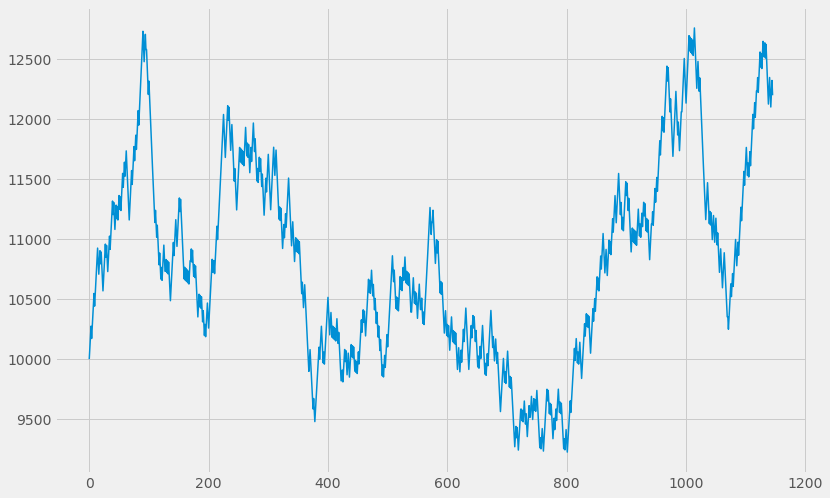

min balance: 9226.133349762393 
max balance: 12759.053645231848 
final balance: 12309.349492526091


,index,GAME_DATE,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size,model_spread_diff
0,19301,2015-12-31,-2.0,-6,-1.776719,0,10000.0,1.0,10000.000000,10090.909091,100.000000,3.776719
1,19302,2016-01-06,-8.0,-9,2.011333,0,0.0,1.0,10090.909091,10182.644628,100.909091,5.988667
2,19304,2016-01-15,-3.5,2,0.402801,0,0.0,1.0,10182.644628,10275.214125,101.826446,3.097199
3,19316,2016-02-27,-2.0,-2,6.414521,1,0.0,0.0,10275.214125,10172.461983,102.752141,4.414521
4,19319,2016-03-07,1.5,3,3.884947,1,1.0,1.0,10172.461983,10264.938911,101.724620,5.384947
...,...,...,...,...,...,...,...,...,...,...,...,...
1141,24084,2020-01-31,-7.5,28,1.593433,0,1.0,0.0,12222.888005,12100.659125,122.228880,5.906567
1142,24087,2020-02-13,-3.5,-5,0.445249,0,0.0,1.0,12100.659125,12210.665117,121.006591,3.054751
1143,24089,2020-03-01,-1.5,-8,-4.420416,0,0.0,1.0,12210.665117,12321.671164,122.106651,5.920416
1144,24091,2020-03-06,-1.5,6,-2.273892,0,1.0,0.0,12321.671164,12198.454452,123.216712,3.773892


In [834]:

simulate_bets(select_bets)

Using ELO and a betting strategy of betting games where our model differs from the vegas spread by 3-6 points and avoiding games with larger than 10 point spreads, we are able to make a profit of \\$2309 

In [713]:
betting_results

(1307, 1259) 
 (1029, 1130)


In [714]:
pushes_removed = betting_results.loc[betting_results['home_cover'] != 0.5]
confusion_matrix(pushes_removed['home_cover'], pushes_removed['bet_home'])

array([[1130, 1259],
       [1029, 1307]], dtype=int64)

In [715]:
(1307+1130) / (1130+1259+1029+1307)

0.5157671957671958

In [633]:
features = full_df.iloc[:, 13:-4]

features
point_diff = full_df['point_diff']
win = full_df['WL']
total = full_df['HOME_TEAM_SCORE'] + full_df['AWAY_TEAM_SCORE']

In [634]:
cutoff = int(features.shape[0] * 0.8)
X_train = features.iloc[:cutoff, :]
X_test = features.iloc[cutoff:, :]
point_diff_train = point_diff.iloc[:cutoff]
point_diff_test = point_diff.iloc[cutoff:]
win_train = win.iloc[:cutoff]
win_test = win.iloc[cutoff:]
total_train = total.iloc[:cutoff]
total_test = total.iloc[cutoff:]

In [635]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression Predicting Spread

In [463]:
lr = LinearRegression()

lr.fit(X_train, point_diff_train)

y_preds = lr.predict(X_test)

linreg_mse = mean_squared_error(point_diff_test, y_preds)
linreg_mae = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", linreg_mse, "mean absolute error:", linreg_mae)

mean squared error: 176.67169466211152 mean absolute error: 10.441528574290318


In [283]:
# sorted(list(zip(features.columns, lr.coef_)), key = lambda x: x[1])

In [500]:
betting_results = full_df[['spread', 'point_diff']].iloc[cutoff:, :]
betting_results['model_preds'] = y_preds


betting_results['bet_home'] = (betting_results['model_preds'] + betting_results['spread'] > 0).astype(int)
betting_results['home_cover'] = (betting_results['point_diff'] + betting_results['spread'] > 0).astype(int)
betting_results.loc[betting_results['spread'] + betting_results['point_diff'] == 0, 'home_cover'] = 0.5
betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
betting_results.loc[betting_results['home_cover'] == 0.5, 'bet_won'] = 0.5

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bankroll_i'].iloc[0] = 10000
betting_results['bet_size'] = np.nan

# betting_results['bet_size'] = 
betting_results

simulate_bets(betting_results)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size
19276,-4.5,5,5.786142,1,1.0,1.0,10000.000000,10090.909091,100.000000
19277,-6.0,23,2.563208,0,1.0,0.0,10090.909091,9990.000000,100.909091
19278,-10.0,1,8.959846,0,0.0,1.0,9990.000000,10080.818182,99.900000
19279,-11.5,20,5.885853,0,1.0,0.0,10080.818182,9980.010000,100.808182
19280,-4.5,-4,5.319006,1,0.0,0.0,9980.010000,9880.209900,99.800100
...,...,...,...,...,...,...,...,...,...
24091,-1.5,6,1.745681,1,1.0,1.0,3082.111552,3110.130748,30.821116
24092,-2.5,-2,-23.505078,0,0.0,1.0,3110.130748,3138.404664,31.101307
24093,-5.0,10,2.028545,0,1.0,0.0,3138.404664,3107.020617,31.384047
24094,-8.0,11,4.722825,0,1.0,0.0,3107.020617,3075.950411,31.070206


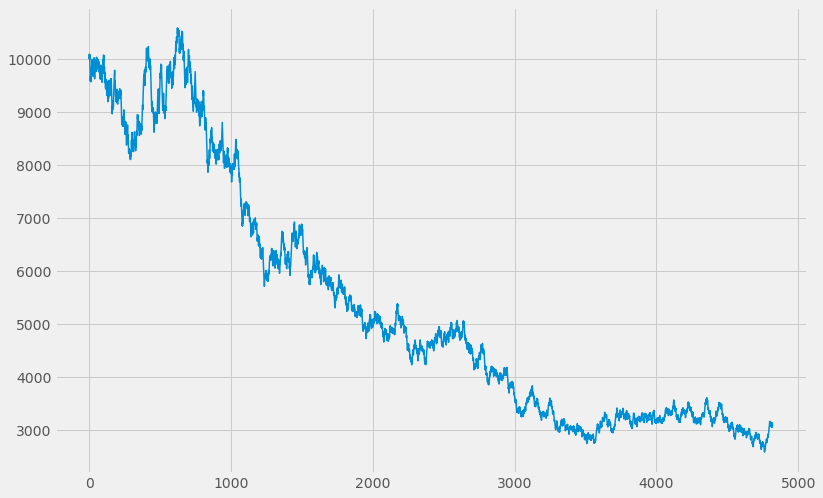

,spread,point_diff,model_preds,bet_home,home_cover,bet_won,bankroll_i,bankroll_n,bet_size
19276,-4.5,5,5.786142,1,1.0,1.0,10000.000000,10090.909091,100.000000
19277,-6.0,23,2.563208,0,1.0,0.0,10090.909091,9990.000000,100.909091
19278,-10.0,1,8.959846,0,0.0,1.0,9990.000000,10080.818182,99.900000
19279,-11.5,20,5.885853,0,1.0,0.0,10080.818182,9980.010000,100.808182
19280,-4.5,-4,5.319006,1,0.0,0.0,9980.010000,9880.209900,99.800100
...,...,...,...,...,...,...,...,...,...
24091,-1.5,6,1.745681,1,1.0,1.0,3082.111552,3110.130748,30.821116
24092,-2.5,-2,-23.505078,0,0.0,1.0,3110.130748,3138.404664,31.101307
24093,-5.0,10,2.028545,0,1.0,0.0,3138.404664,3107.020617,31.384047
24094,-8.0,11,4.722825,0,1.0,0.0,3107.020617,3075.950411,31.070206


In [508]:
simulate_bets(betting_results)

In [509]:
betting_results['bet_won'].value_counts()

1.0    2425
0.0    2300
0.5      95
Name: bet_won, dtype: int64

<AxesSubplot:ylabel='Frequency'>

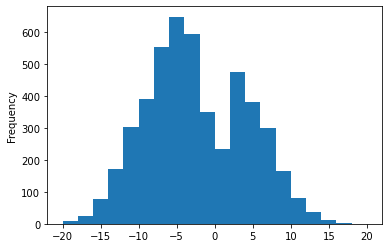

In [477]:
betting_results['spread'].plot(kind='hist', bins=20, range=(-20, 20))

### Linear Regression Predicting Total

In [637]:
lr = LinearRegression()

lr.fit(X_train, total_train)

y_preds = lr.predict(X_test)

lr_mse_total = mean_squared_error(total_test, y_preds)
lr_mae_total = mean_absolute_error(total_test, y_preds)

print("mse:", lr_mse_total, "mae:", lr_mae_total)

mse: 365.7964958040015 mae: 15.030883673884738


Optimal Number of Features: 58


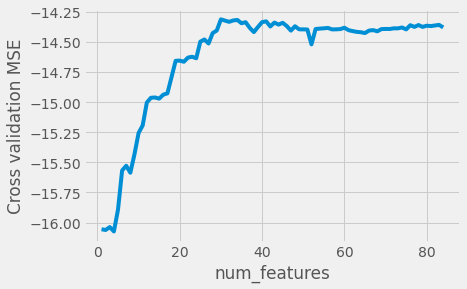

In [645]:
rfecv = select_features(LinearRegression(), X_train, total_train, min_features_to_select=1, cv_splits=5)



In [647]:
X_train_select = X_train[:, rfecv.support_]
X_test_select = X_test[:, rfecv.support_]

lr = LinearRegression()
lr.fit(X_train_select, total_train)

y_preds = lr.predict(X_test_select)

lr_mse_total = mean_squared_error(total_test, y_preds)
lr_mae_total = mean_absolute_error(total_test, y_preds)

print("mse:", lr_mse_total, "mae:", lr_mae_total)

mse: 367.3602661965781 mae: 15.106553557788002


In [648]:
y_preds

array([212.72337146, 223.91530543, 214.0758076 , ..., 233.16270004,
       233.09839153, 239.84808115])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


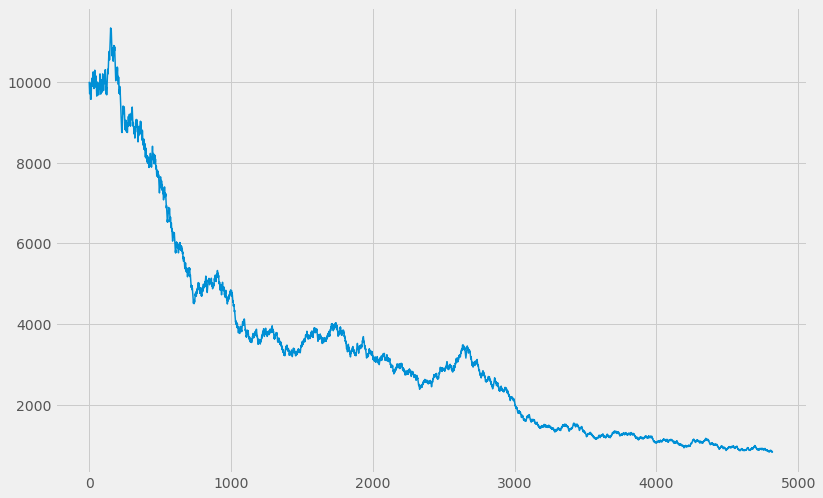

,total,AWAY_TEAM_SCORE,HOME_TEAM_SCORE,actual_total,model_preds,bet_over,over_correct,bet_won,bankroll_i,bankroll_n,bet_size
19276,205.0,95,100,195,212.723371,1,0.0,0.0,10000.000000,9900.000000,100.000000
19277,220.0,93,116,209,223.915305,1,0.0,0.0,9900.000000,9801.000000,99.000000
19278,210.0,104,105,209,214.075808,1,0.0,0.0,9801.000000,9702.990000,98.010000
19279,210.5,96,116,212,218.126932,1,1.0,1.0,9702.990000,9791.199000,97.029900
19280,224.5,102,98,200,223.905776,0,0.0,1.0,9791.199000,9880.209900,97.911990
...,...,...,...,...,...,...,...,...,...,...,...
24091,232.0,104,110,214,236.554067,1,0.0,0.0,854.697745,846.150768,8.546977
24092,229.0,106,104,210,229.642483,1,0.0,0.0,846.150768,837.689260,8.461508
24093,236.5,99,109,208,233.162700,0,0.0,1.0,837.689260,845.304617,8.376893
24094,236.0,107,118,225,233.098392,0,0.0,1.0,845.304617,852.989204,8.453046


In [652]:
betting_results = full_df[['total', 'AWAY_TEAM_SCORE', 'HOME_TEAM_SCORE']].iloc[cutoff:, :]
betting_results['actual_total'] = betting_results['AWAY_TEAM_SCORE'] + betting_results['HOME_TEAM_SCORE']
betting_results['model_preds'] = y_preds


betting_results['bet_over'] = (betting_results['model_preds'] > betting_results['total']).astype(int)
betting_results['over_correct'] = (betting_results['actual_total'] > betting_results['total']).astype(int)
betting_results.loc[betting_results['total'] == betting_results['actual_total'], 'over_correct'] = 0.5
betting_results['bet_won'] = (betting_results['bet_over'] == betting_results['over_correct']).astype(int)
betting_results.loc[betting_results['over_correct'] == 0.5, 'bet_won'] = 0.5

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bankroll_i'].iloc[0] = 10000
betting_results['bet_size'] = np.nan

betting_results

simulate_bets(betting_results)

In [654]:
betting_results['bet_won'].value_counts()

0.0    2389
1.0    2380
0.5      51
Name: bet_won, dtype: int64

In [447]:
tscv = TimeSeriesSplit(n_splits=5)


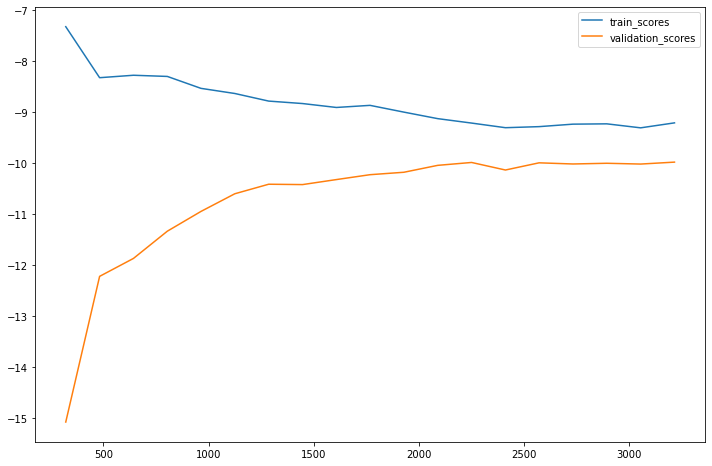

In [317]:
train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(normalize=True), X_train, point_diff_train,
                                                        train_sizes = np.linspace(0.1, 1, 19), cv = tscv,
                                                        scoring='neg_mean_absolute_error')

mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = valid_scores.mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_sizes, mean_train_scores, label='train_scores')
ax.plot(train_sizes, mean_val_scores, label='validation_scores')
plt.legend()
plt.show()

In [449]:
def select_features(estimator, X, y, min_features_to_select, cv_splits):
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    min_features_to_select = min_features_to_select

    rfecv = RFECV(estimator = LinearRegression(),
          step=2, cv = tscv,
         scoring='neg_mean_absolute_error', 
                  min_features_to_select= min_features_to_select,
         n_jobs = -1)

    rfecv.fit(X, y)

    print("Optimal Number of Features:", rfecv.n_features_)

    plt.figure()
    plt.xlabel("num_features")
    plt.ylabel("Cross validation MSE")
    plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
    plt.show()
    
    mask = rfecv.support_
        
    return rfecv, rfecv.support_
    

Optimal Number of Features: 138


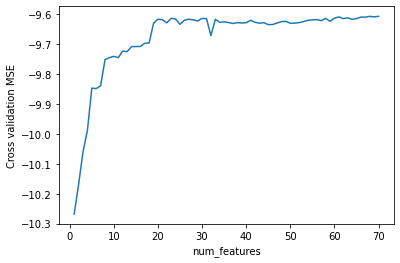

In [450]:
rfecv = select_features(LinearRegression(), X_train, point_diff_train, min_features_to_select=1, cv_splits=5)

In [453]:
selected_cols = features.iloc[:, rfecv.support_].columns

X_train_select = X_train[:, rfecv.support_]
X_test_select = X_test[:, rfecv.support_]

pd.DataFrame(X_train_select, columns=selected_cols)

,HOME_MIN,HOME_RECORD,HOME_FG2M,HOME_FG2A,HOME_FG3M,HOME_FG3A,HOME_FTM,HOME_FTA,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,HOME_PTS,HOME_PLUS_MINUS,HOME_E_OFF_RATING,HOME_OFF_RATING,HOME_E_DEF_RATING,HOME_DEF_RATING,HOME_E_NET_RATING,HOME_NET_RATING,HOME_POSS,HOME_PIE,HOME_PTS_2PT_MR,HOME_PTS_FB,HOME_PTS_OFF_TOV,HOME_PTS_PAINT,HOME_AST_2PM,HOME_UAST_2PM,HOME_AST_3PM,HOME_UAST_3PM,HOME_MIN_opp,HOME_RECORD_opp,HOME_FG2M_opp,HOME_FG2A_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_STL_opp,HOME_BLK_opp,HOME_TOV_opp,HOME_PF_opp,HOME_PTS_opp,HOME_PLUS_MINUS_opp,HOME_E_OFF_RATING_opp,HOME_OFF_RATING_opp,HOME_E_DEF_RATING_opp,HOME_DEF_RATING_opp,HOME_E_NET_RATING_opp,HOME_NET_RATING_opp,HOME_POSS_opp,HOME_PIE_opp,HOME_PTS_2PT_MR_opp,HOME_PTS_FB_opp,HOME_PTS_OFF_TOV_opp,HOME_PTS_PAINT_opp,HOME_AST_2PM_opp,HOME_UAST_2PM_opp,HOME_AST_3PM_opp,HOME_UAST_3PM_opp,HOME_rest,AWAY_MIN,AWAY_RECORD,AWAY_FG2M,AWAY_FG2A,AWAY_FG3M,AWAY_FG3A,AWAY_FTM,AWAY_FTA,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_E_OFF_RATING,AWAY_OFF_RATING,AWAY_E_DEF_RATING,AWAY_DEF_RATING,AWAY_E_NET_RATING,AWAY_NET_RATING,AWAY_POSS,AWAY_PIE,AWAY_PTS_2PT_MR,AWAY_PTS_FB,AWAY_PTS_OFF_TOV,AWAY_PTS_PAINT,AWAY_AST_2PM,AWAY_UAST_2PM,AWAY_AST_3PM,AWAY_UAST_3PM,AWAY_MIN_opp,AWAY_RECORD_opp,AWAY_FG2M_opp,AWAY_FG2A_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_STL_opp,AWAY_BLK_opp,AWAY_TOV_opp,AWAY_PF_opp,AWAY_PTS_opp,AWAY_PLUS_MINUS_opp,AWAY_E_OFF_RATING_opp,AWAY_OFF_RATING_opp,AWAY_E_DEF_RATING_opp,AWAY_DEF_RATING_opp,AWAY_E_NET_RATING_opp,AWAY_NET_RATING_opp,AWAY_POSS_opp,AWAY_PIE_opp,AWAY_PTS_2PT_MR_opp,AWAY_PTS_FB_opp,AWAY_PTS_OFF_TOV_opp,AWAY_PTS_PAINT_opp,AWAY_AST_2PM_opp,AWAY_UAST_2PM_opp,AWAY_AST_3PM_opp,AWAY_UAST_3PM_opp,AWAY_rest
0,-0.748977,-0.505279,-1.396412,-0.761323,-0.281057,-0.341124,1.661259,1.421236,0.279531,-1.463888,-1.057925,-1.028583,0.814625,-0.618465,1.225925,0.343945,-0.654529,0.508792,-0.467562,-0.294110,-0.907279,-1.076514,0.313564,0.596312,-0.831363,0.209120,-0.439959,-1.505246,1.009669,-0.949160,-0.568960,-0.881891,-0.383918,0.338312,-0.748977,0.505279,-0.282531,-0.317887,-0.990441,-1.229597,-0.441136,-0.104483,-0.725441,-0.808000,-1.073107,-0.434632,-0.837311,-0.475831,1.179273,0.804702,-1.147422,-0.508792,-0.907279,-1.076514,-0.467562,-0.294110,-0.313564,-0.596312,-0.701243,-0.209206,0.873363,-1.762358,0.805405,-0.942267,-0.019268,-0.215882,-0.605315,-1.569289,-0.256908,-0.746157,1.369370,0.442225,1.269058,-1.351687,-1.178552,1.428658,1.687976,0.812306,0.689227,1.121497,0.535260,1.738874,-0.972866,0.994338,1.263858,-0.348156,1.355907,-1.100515,-1.020692,-2.560906,-2.871977,1.054897,1.393113,0.884702,1.576898,1.176652,-0.720958,2.081950,-0.704026,1.298992,-0.976133,-1.096568,-1.224404,-0.746157,-1.369370,0.156174,1.023728,-1.774214,-1.236664,-1.028192,-0.394294,1.214645,0.119562,0.764531,-1.436993,0.940460,2.886337,2.733704,1.800441,-1.655746,-1.355907,-2.560906,-2.871977,-1.100515,-1.020692,-1.054897,-1.393113,1.002886,-1.576965,-1.314626,-0.727168,0.212059,1.104088,-0.377180,0.707349,-1.813698,-0.574687,-1.005328
1,-0.748977,-0.623864,-1.013147,-0.692433,-0.672556,-0.606310,1.389427,1.095236,-0.309204,-2.181035,-2.053343,-1.237674,0.638973,-1.003163,1.240536,0.287010,-0.855947,-0.152995,-0.646903,-0.661304,-0.459088,-0.580982,-0.163908,-0.087005,-0.676517,-0.106590,-0.386822,-1.718883,0.717405,-0.585937,-0.747270,-0.274514,-0.592176,-0.396451,-0.748977,0.623864,0.047323,-0.115688,-0.698792,-1.547714,-0.515488,-0.141149,-1.096202,-0.565217,-1.073107,-0.338969,-1.148188,-0.264414,1.334754,1.208653,-0.711007,0.152995,-0.459088,-0.580982,-0.646903,-0.661304,0.163908,0.087005,-0.593656,0.106505,0.782656,-0.899611,0.816255,-0.607809,-0.007411,0.096651,-0.624145,-0.502205,-0.256908,-0.746157,-1.633277,-2.534982,0.029251,-1.075428,-1.

In [456]:
lr.fit(X_train_select, point_diff_train)

y_preds = lr.predict(X_test_select)

r2_score = lr.score(X_test_select, point_diff_test)

linreg_mse_select = mean_squared_error(point_diff_test, y_preds)
linreg_mae_select = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", linreg_mse_select, "mean absolute error:", linreg_mae_select, "r2_score:", r2_score)

mean squared error: 176.67169466211152 mean absolute error: 10.441528574290318 r2_score: 0.10136011136483936


In [460]:
X_test
# bet_data_clean

array([[ 0.24855923,  0.91773698,  1.34696214, ...,  1.50634075,
         0.92530547,  0.0290855 ],
       [ 0.24855923,  0.91773698,  1.18558717, ...,  0.44996478,
         0.92530547, -1.00532809],
       [ 0.24855923,  0.91773698,  1.38730588, ...,  0.29905392,
         0.67530678,  1.06349909],
       ...,
       [ 0.24855923, -0.50527897,  0.62077479, ...,  3.6190927 ,
         2.92529498, -1.00532809],
       [ 0.24855923, -0.50527897,  0.58043105, ...,  2.10998417,
         2.92529498,  0.0290855 ],
       [ 0.24855923, -0.50527897,  0.21733738, ...,  4.75092411,
         0.92530547,  0.0290855 ]])

In [325]:
X_train.shape

(19271, 164)

In [353]:

ridge = RidgeCV(alphas = [0.1, 0.3, 0.5, 0.7, 1, 3, 10], cv=tscv, 
                scoring='neg_mean_squared_error')

ridge.fit(X_train, point_diff_train)

print("best_alpha: ", ridge.alpha_)
print("best_score: ", ridge.best_score_)
y_preds = ridge.predict(X_test)

ridge_mse = mean_squared_error(point_diff_test, y_preds)
ridge_mae = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", ridge_mse, "mean absolute error:", ridge_mae)


best_alpha:  10.0
best_score:  -147.48338088482112
mean squared error: 173.7289463547496 mean absolute error: 10.371806547688983


In [356]:

lasso_cv = LassoCV(cv=tscv)

lasso_cv.fit(X_train, point_diff_train)

print("best_alpha: ", lasso_cv.alpha_)

lasso = Lasso(alpha = lasso_cv.alpha_)

lasso.fit(X_train, point_diff_train)

y_preds = lasso.predict(X_test)

lasso_mse = mean_squared_error(point_diff_test, y_preds)
lasso_mae = mean_absolute_error(point_diff_test, y_preds)

print("mean squared error:", lasso_mse, "mean absolute error:", lasso_mae)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.03315748774912, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.73371798050357, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.49391876423033, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: Convergenc

best_alpha:  0.060299990012402174
mean squared error: 173.1295015658412 mean absolute error: 10.366415142142827


In [362]:
en = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], max_iter=10000, cv=tscv)
en.fit(X_train, point_diff_train)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.781081585912034, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.86134070303524, tolerance: 52.38037434701493
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.73763998353388, tolerance: 99.96807456044813
  tol, rng, random, positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: Convergenc

ElasticNetCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=10000)

In [363]:
en.alpha_

0.32180291034093467

In [364]:
en.l1_ratio_

0.1

In [457]:
logr = LogisticRegression(solver='liblinear')

logr.fit(X_train, win_train)

score = logr.score(X_test, win_test)

print(score)


0.6360995850622406


In [268]:
win_pred = logr.predict(X_test)

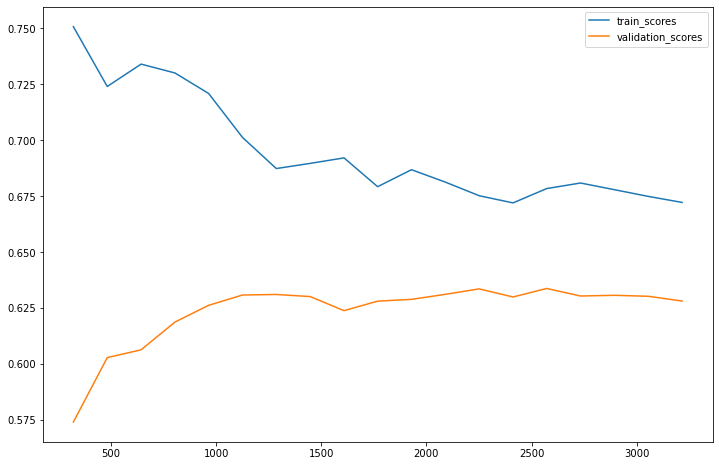

In [315]:
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(solver='liblinear'), X_train, win_train,
                                                        train_sizes = np.linspace(0.1, 1, 19), cv = tscv)

mean_train_scores = train_scores.mean(axis=1)
mean_val_scores = valid_scores.mean(axis=1)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train_sizes, mean_train_scores, label='train_scores')
ax.plot(train_sizes, mean_val_scores, label='validation_scores')
plt.legend()
plt.show()

In [269]:
test = pd.DataFrame({'model_predictions':y_preds, 'actual_point_diff':point_diff_test, "model_win_prediction": win_pred, "actual_win_result": win_test})

test

,model_predictions,actual_point_diff,model_win_prediction,actual_win_result
19271,5.351108,7,1,1
19272,6.533092,9,1,1
19273,3.439585,5,1,1
19274,9.226603,5,1,1
19275,3.850905,12,1,1
...,...,...,...,...
24084,4.072028,6,1,1
24085,2.799928,-2,1,0
24086,2.218355,10,1,1
24087,6.796124,11,1,1


In [270]:
test['predict_home_winner'] = (test['model_predictions'] > 0).astype(int)

In [273]:
test['predict_home_winner'] == test['model_win_prediction']

19271    True
19272    True
19273    True
19274    True
19275    True
         ... 
24084    True
24085    True
24086    True
24087    True
24088    True
Length: 4818, dtype: bool

In [278]:
test['models_match'] = (test['predict_home_winner'] == test['model_win_prediction']).astype(int)
test.loc[test['models_match'] == 0]

,model_predictions,actual_point_diff,model_win_prediction,actual_win_result,predict_home_winner,models_match
19283,0.171256,12,0,1,1,0
19320,-0.710795,-5,1,0,0,0
19332,1.783913,9,0,1,1,0
19366,0.427932,6,0,1,1,0
19369,-0.884417,31,1,1,0,0
...,...,...,...,...,...,...
24019,-0.321605,19,1,1,0,0
24042,0.095976,-5,0,0,1,0
24069,-1.460965,15,1,1,0,0
24077,1.314890,28,0,1,1,0


### Random Forest Predict Point Spread

In [656]:
X_train.shape, total_train.shape

((19276, 166), (19276,))

In [657]:
from sklearn.ensemble import RandomForestRegressor
max_features = list(np.linspace(0.2, 1, 10))
max_depth = np.arange(2, 32, 4)
max_features.append('auto')
params = {'max_depth':max_depth, 
         'max_features': max_features}

gs_rf = GridSearchCV(RandomForestRegressor(), param_grid=params, scoring='neg_mean_squared_error', verbose=2, cv=tscv)

gs_rf.fit(X_train, total_train)



Fitting 5 folds for each of 88 candidates, totalling 440 fits
[CV] max_depth=2, max_features=0.2 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=2, max_features=0.2, total=   3.9s
[CV] max_depth=2, max_features=0.2 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] .................... max_depth=2, max_features=0.2, total=   3.6s
[CV] max_depth=2, max_features=0.2 ...................................
[CV] .................... max_depth=2, max_features=0.2, total=   3.6s
[CV] max_depth=2, max_features=0.2 ...................................
[CV] .................... max_depth=2, max_features=0.2, total=   3.7s
[CV] max_depth=2, max_features=0.2 ...................................
[CV] .................... max_depth=2, max_features=0.2, total=   3.7s
[CV] max_depth=2, max_features=0.2888888888888889 ....................
[CV] ..... max_depth=2, max_features=0.2888888888888889, total=   5.1s
[CV] max_depth=2, max_features=0.2888888888888889 ....................
[CV] ..... max_depth=2, max_features=0.2888888888888889, total=   5.1s
[CV] max_depth=2, max_features=0.2888888888888889 ....................
[CV] ..... max_depth=2, max_features=0.2888888888888889, total=   5.1s
[CV] max_depth=2, max_features=0.2888888888888889 ....................
[CV] .

[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed: 468.5min finished


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 2,  6, 10, 14, 18, 22, 26, 30]),
                         'max_features': [0.2, 0.2888888888888889,
                                          0.37777777777777777,
                                          0.4666666666666667,
                                          0.5555555555555556,
                                          0.6444444444444445,
                                          0.7333333333333334,
                                          0.8222222222222222,
                                          0.9111111111111112, 1.0, 'auto']},
             scoring='neg_mean_squared_error', verbose=2)

In [658]:
print(gs_rf.best_params_)
best_rf = gs_rf.best_estimator_
y_preds = best_rf.predict(X_test)
mae = mean_absolute_error(total_test, y_preds)
mse = mean_squared_error(total_test, y_preds)
print('mae:', mae)

{'max_depth': 10, 'max_features': 0.2888888888888889}
mae: 15.519578952157952


In [659]:
y_preds

array([205.74019359, 217.54525072, 210.78817095, ..., 219.36898161,
       219.39432272, 220.69016304])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


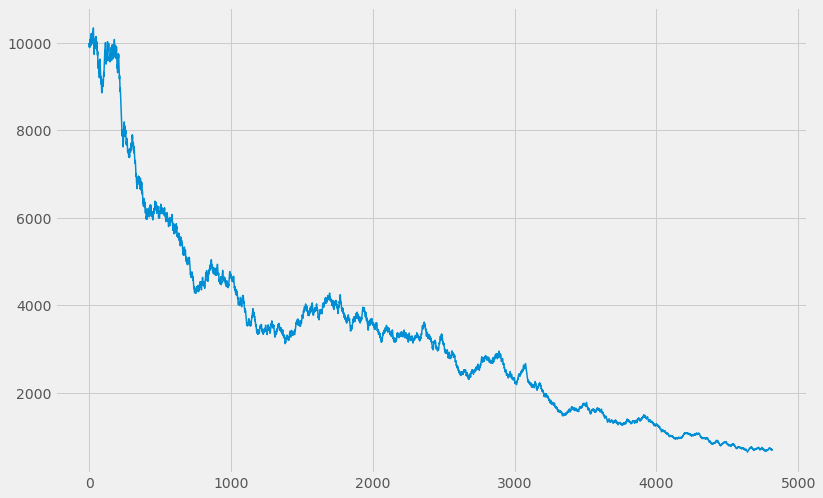

In [669]:
betting_results = full_df[['total', 'AWAY_TEAM_SCORE', 'HOME_TEAM_SCORE']].iloc[cutoff:, :]
betting_results['actual_total'] = betting_results['AWAY_TEAM_SCORE'] + betting_results['HOME_TEAM_SCORE']
betting_results['model_preds'] = y_preds


betting_results['bet_over'] = (betting_results['model_preds'] > betting_results['total']).astype(int)
betting_results['over_correct'] = (betting_results['actual_total'] > betting_results['total']).astype(int)
betting_results.loc[betting_results['total'] == betting_results['actual_total'], 'over_correct'] = 0.5
betting_results['bet_won'] = (betting_results['bet_over'] == betting_results['over_correct']).astype(int)
betting_results.loc[betting_results['over_correct'] == 0.5, 'bet_won'] = 0.5

betting_results['bankroll_i'] = np.nan
betting_results['bankroll_n'] = np.nan
betting_results['bankroll_i'].iloc[0] = 10000
betting_results['bet_size'] = np.nan

betting_results

rf_total_bet_results = simulate_bets(betting_results)

In [671]:
rf_total_bet_results.head(20)

,total,AWAY_TEAM_SCORE,HOME_TEAM_SCORE,actual_total,model_preds,bet_over,over_correct,bet_won,bankroll_i,bankroll_n,bet_size
19276,205.0,95,100,195,205.740194,1,0.0,0.0,10000.000000,9900.000000,100.000000
19277,220.0,93,116,209,217.545251,0,0.0,1.0,9900.000000,9990.000000,99.000000
19278,210.0,104,105,209,210.788171,1,0.0,0.0,9990.000000,9890.100000,99.900000
19279,210.5,96,116,212,214.291256,1,1.0,1.0,9890.100000,9980.010000,98.901000
19280,224.5,102,98,200,221.852722,0,0.0,1.0,9980.010000,10070.737364,99.800100
19281,220.0,130,109,239,218.110430,0,1.0,0.0,10070.737364,9970.029990,100.707374
19282,217.0,96,107,203,210.880776,0,0.0,1.0,9970.029990,10060.666626,99.700300
19283,205.5,79,91,170,213.033712,1,0.0,0.0,10060.666626,9960.059960,100.606666
19284,207.5,97,104,201,205.120585,0,0.0,1.0,9960.059960,10050.605960,99.600600
19285,204.0,109,124,233,204.114778,1,1.0,1.0,10050.605960,10141.975105,100.506060
